In [1]:
import pandas as pd 
from pymongo import MongoClient
import matplotlib.pyplot as plt
import time
import datetime
from IPython.display import clear_output
from scipy.interpolate import make_interp_spline
import numpy as np 

In [2]:
client = MongoClient()
client.DallasPD_DB
db = client['DallasPD_DB']
dpd_db = db.running_db
df = pd.DataFrame(list(dpd_db.find()))

In [3]:
df = pd.DataFrame(list(dpd_db.find()))
df.columns
dfc = df.drop('_id', axis = 1)
dfc = dfc.drop_duplicates()
dfc.sort_values(by = ['date', 'time']).head()
dfc['datetime'] = pd.to_datetime(dfc['date'].astype(str) + ' ' + dfc['time'])
dfc['day'] = dfc['datetime'].dt.day

In [4]:
# get non unique incidents 
all_incidents = dfc['incident_number'].to_list()
incident_dict = {}
for incident in all_incidents:
    if incident in incident_dict.keys():
        incident_dict[incident] = incident_dict[incident] + 1
    else:
        incident_dict[incident] = 1
        
advanced_incidents = []
for i in incident_dict:
    if incident_dict[i] >1:
        advanced_incidents.append(i)
dfc[dfc['incident_number']=='25-0285764']
# https://dallaspolice.net/resources/CrimeReports/Calls%20by%20Problem%20Type.pdf

,incident_number,division,nature_of_call,priority,date,time,unit_number,location,beat,reporting_area,status,block,datetime,day
16,25-0285764,Southeast,41/11V - BMV-In Progress,2,2025-02-17,23:31:39,E383,Stonehurst St,333,1253,At Scene,8100,2025-02-17 23:31:39,17
17,25-0285764,Southeast,41/11V - BMV-In Progress,2,2025-02-17,23:31:39,E372,Stonehurst St,333,1253,At Scene,8100,2025-02-17 23:31:39,17
18,25-0285764,Southeast,41/11V - BMV-In Progress,2,2025-02-17,23:31:39,K6,Stonehurst St,333,1253,At Scene,8100,2025-02-17 23:31:39,17
19,25-0285764,Southeast,41/11V - BMV-In Progress,2,2025-02-17,23:31:39,E332,Stonehurst St,333,1253,At Scene,8100,2025-02-17 23:31:39,17
20,25-0285764,Southeast,41/11V - BMV-In Progress,2,2025-02-17,23:31:39,UAS34,Stonehurst St,333,1253,At Scene,8100,2025-02-17 23:31:39,17
21,25-0285764,Southeast,41/11V - BMV-In Progress,2,2025-02-17,23:31:39,E380,Stonehurst St,333,1253,At Scene,8100,2025-02-17 23:31:39,17
22,25-0285764,Southeast,41/11V - BMV-In Progress,2,2025-02-17,23:31:39,E316,Stonehurst St,333,1253,At Scene,8100,2025-02-17 23:31:39,17


1 60


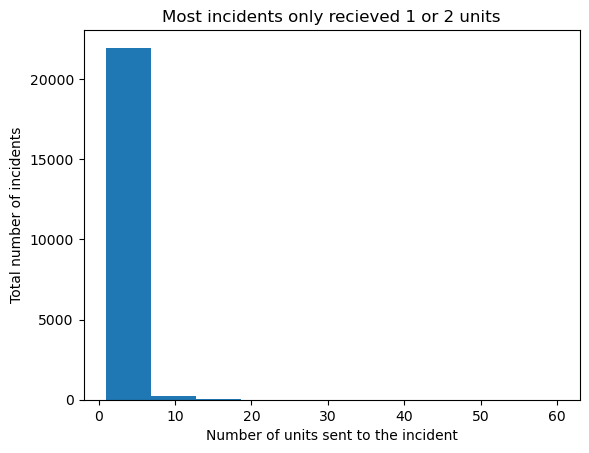

In [5]:
plt.hist(incident_dict.values(), bins = 10)
plt.title("Most incidents only recieved 1 or 2 units")
plt.xlabel('Number of units sent to the incident')
plt.ylabel('Total number of incidents')
print(min(incident_dict.values()), max(incident_dict.values()))

In [6]:
def incidents_by_num_units(num_units, equals_to):
    if equals_to:
        filtered_dict = {key: value for key, value in incident_dict.items() if value == num_units}
    else:
        filtered_dict = {key: value for key, value in incident_dict.items() if value >= num_units}
    return filtered_dict

def subset_df(incident_numbers):
    return dfc[dfc['incident_number'].isin(incident_numbers.keys())].sort_values(by = ['incident_number', 'unit_number'])

In [7]:
subset_df(incidents_by_num_units(13, False))['incident_number'].unique()

array(['25-0286372', '25-0292252', '25-0308863', '25-0318532',
       '25-0356764', '25-0359032', '25-0366296', '25-0373249',
       '25-0373298', '25-0380122', '25-0389314', '25-0392457',
       '25-0393319', '25-0397582', '25-0398954', '25-0412652',
       '25-0416869', '25-0417503', '25-0418451', '25-0423175',
       '25-0424701', '25-0431090', '25-0443774', '25-0444886',
       '25-0450966', '25-0457531', '25-0471388', '25-0481340',
       '25-0481780', '25-0484739', '25-0491666', '25-0501990',
       '25-0505592'], dtype=object)

In [8]:
dfc.groupby(['date']).agg('count')['incident_number']

date
2025-02-17      31
2025-02-18    1229
2025-02-19     760
2025-02-20     746
2025-02-21     854
2025-02-22     717
2025-02-23     567
2025-02-24     606
2025-02-25     674
2025-02-26     671
2025-02-27    1296
2025-02-28     795
2025-03-01     796
2025-03-02     754
2025-03-03    1394
2025-03-04    1179
2025-03-05     669
2025-03-06    1005
2025-03-07    1546
2025-03-08    1734
2025-03-09    1696
2025-03-10    1728
2025-03-11    1584
2025-03-12    1682
2025-03-13    1423
2025-03-14    1054
2025-03-15    1339
2025-03-16     673
2025-03-17     752
2025-03-18     508
2025-03-19     569
2025-03-20     947
2025-03-21     695
2025-03-22     655
2025-03-23     630
2025-03-24     924
2025-03-25     346
Name: incident_number, dtype: int64

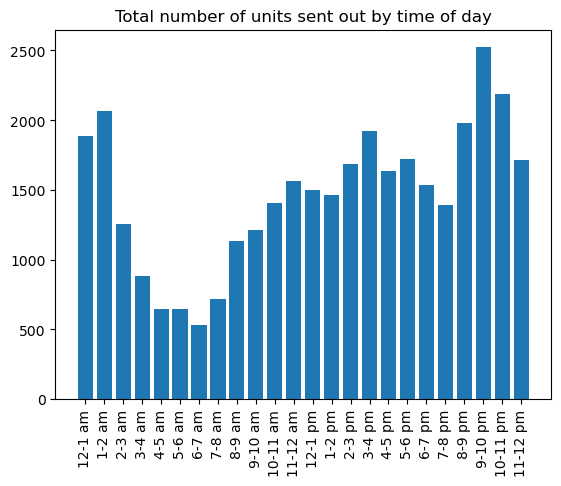

In [9]:
# Total number of units sent out by time of day 
units_by_hour = dfc.groupby(dfc['datetime'].dt.hour).agg('count')[['incident_number']]
units_by_hour= units_by_hour.reset_index()
units_by_hour = units_by_hour.sort_values(by= 'datetime')
x = units_by_hour['datetime']
y = units_by_hour['incident_number']
plt.bar(x, y, tick_label=["12-1 am", "1-2 am", "2-3 am", "3-4 am", "4-5 am", "5-6 am", "6-7 am", "7-8 am", "8-9 am", "9-10 am", "10-11 am", "11-12 am", "12-1 pm", "1-2 pm", "2-3 pm", "3-4 pm", "4-5 pm", "5-6 pm", "6-7 pm", "7-8 pm", "8-9 pm", "9-10 pm", "10-11 pm", "11-12 pm"])
plt.xticks(rotation = 90)
plt.title("Total number of units sent out by time of day")
plt.show()

In [10]:
# number of incidents by time of day 
"""
interesting because it shows the variety of police activity for each category 
ex between midnight and 1 am there have been 50 unique incidents, 7 divisions hving incidents, 
23 different call natures, 4 different priority levels, ..... in the past 3 days
"""
dfc['hour'] = dfc['datetime'].dt.hour
dfc['minute'] = dfc['datetime'].dt.minute
dfc['priority'] = pd.to_numeric(dfc['priority'], errors='coerce')
incidents_by_hour = dfc.groupby(['hour']).nunique('incident_number')
incidents_by_hour.head()

,incident_number,division,nature_of_call,priority,date,time,unit_number,location,beat,reporting_area,status,block,datetime,day,minute
hour,,,,,,,,,,,,,,,
0,1140,7,73,4,29,963,492,737,227,548,1,154,1133,24,60
1,1182,7,69,4,29,991,447,777,224,573,1,149,1177,25,60
2,749,7,71,4,26,669,393,539,214,438,1,145,746,23,60
3,520,7,58,4,22,491,326,406,200,360,1,122,517,21,60
4,379,7,56,4,21,357,256,315,171,290,1,111,375,21,60


In [11]:
mean_hourly_activity = dfc.groupby(['hour', 'date']).nunique().groupby(['hour']).mean()
mean_hourly_activity.drop(axis ='columns', columns = ['time', 'status', 'datetime'], inplace = True)
mean_hourly_activity.head()
# block - is crime/ police dispatch more centered/consistent in certain areas - mapping/modeling 

# mean number of-/ mean -
mean_hourly_activity.rename(columns={"incident_number":"incidents", "division":"divisions", "nature_of_call":"call types", "unit_number":"units sent", "location": "locations", "beat":"beats", "reporting_area":"reporting area's"}, inplace =True)              
mean_hourly_activity.reset_index(inplace = True)

In [12]:
# mean number of units dispatched per incident per hour 
mean_upi_ph = dfc.groupby(['hour', 'date', 'incident_number']).nunique().groupby(['hour']).mean()['unit_number']
mean_upi_ph

hour
0     1.655263
1     1.747885
2     1.678238
3     1.700000
4     1.704485
5     1.579075
6     1.508523
7     1.436255
8     1.428212
9     1.515000
10    1.519957
11    1.502397
12    1.562955
13    1.490835
14    1.545371
15    1.538769
16    1.494516
17    1.550045
18    1.564155
19    1.634118
20    1.653300
21    1.659435
22    1.659091
23    1.657640
Name: unit_number, dtype: float64

In [13]:
mean_hourly_activity.head(10)

,hour,incidents,divisions,call types,priority,units sent,locations,beats,reporting area's,block,day,minute
0,0,39.310345,6.517241,15.482759,3.586207,56.068966,37.586207,34.413793,37.034483,28.000000,1.0,25.655172
1,1,40.758621,6.172414,15.862069,3.517241,57.206897,39.068966,35.206897,38.241379,28.793103,1.0,26.758621
2,2,28.807692,6.076923,13.423077,3.307692,40.423077,27.769231,25.769231,26.961538,21.769231,1.0,20.538462
3,3,23.636364,5.090909,11.818182,2.909091,33.000000,22.863636,21.181818,22.545455,17.590909,1.0,17.363636
4,4,18.047619,4.571429,9.333333,2.904762,25.714286,17.952381,15.857143,17.190476,14.142857,1.0,13.761905
5,5,17.125000,4.500000,8.666667,2.833333,22.666667,16.708333,15.791667,16.416667,13.083333,1.0,13.583333
6,6,14.080000,5.000000,8.720000,3.000000,19.120000,13.720000,13.280000,13.640000,10.800000,1.0,11.880000
7,7,16.733333,4.933333,9.366667,2.833333,22.266667,16.500000,15.333333,16.333333,12.666667,1.0,12.966667
8,8,24.812500,5.312500,10.843750,3.093750,29.937500,24.000000,21.687500,23.093750,18.250000,1.0,17.968750
9,9,22.857143,5.514286,10.828571,3.171429,30.457143,22.314286,20.800000,21.914286,16.600000,1.0,17.028571


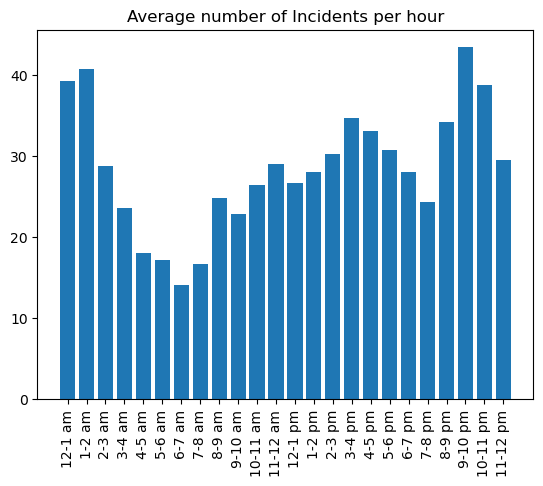

In [14]:
# mean number of incident by time of day 
mha_incidents = mean_hourly_activity[['hour', 'incidents']].sort_values(by='hour')
x = mha_incidents['hour']
y = mha_incidents['incidents']
plt.bar(x, y, tick_label=["12-1 am", "1-2 am", "2-3 am", "3-4 am", "4-5 am", "5-6 am", "6-7 am", "7-8 am", "8-9 am", "9-10 am", "10-11 am", "11-12 am", "12-1 pm", "1-2 pm", "2-3 pm", "3-4 pm", "4-5 pm", "5-6 pm", "6-7 pm", "7-8 pm", "8-9 pm", "9-10 pm", "10-11 pm", "11-12 pm"])
plt.xticks(rotation = 90)
plt.title("Average number of Incidents per hour")
plt.show()

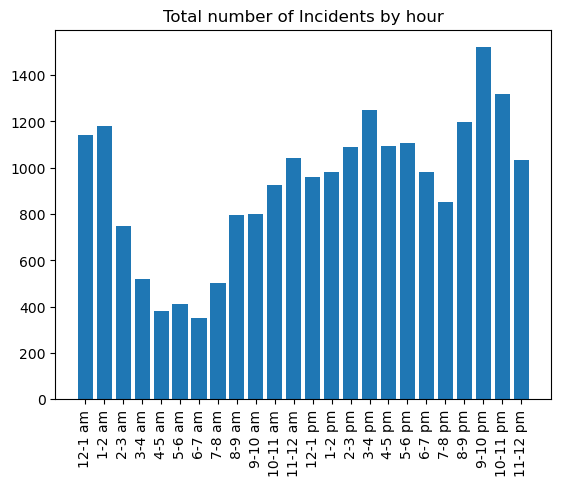

In [15]:
# Total number of incidents per hour 
incidents_by_hour = dfc.groupby(['hour'])['incident_number'].nunique().groupby('hour').sum().reset_index()
x = incidents_by_hour['hour']
y = incidents_by_hour['incident_number']
plt.bar(x, y, tick_label=["12-1 am", "1-2 am", "2-3 am", "3-4 am", "4-5 am", "5-6 am", "6-7 am", "7-8 am", "8-9 am", "9-10 am", "10-11 am", "11-12 am", "12-1 pm", "1-2 pm", "2-3 pm", "3-4 pm", "4-5 pm", "5-6 pm", "6-7 pm", "7-8 pm", "8-9 pm", "9-10 pm", "10-11 pm", "11-12 pm"])
plt.xticks(rotation = 90)
plt.title("Total number of Incidents by hour")
plt.show()

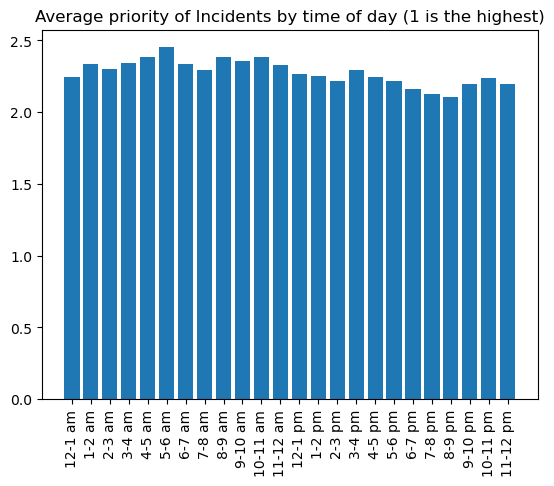

In [16]:
mean_hourly_activity = dfc.groupby(['hour', 'date','incident_number'])[['priority']].mean().groupby(['hour'])['priority'].mean()
mean_hourly_activity = mean_hourly_activity.reset_index()
x = mean_hourly_activity['hour']
y = mean_hourly_activity['priority']
plt.bar(x, y, tick_label=["12-1 am", "1-2 am", "2-3 am", "3-4 am", "4-5 am", "5-6 am", "6-7 am", "7-8 am", "8-9 am", "9-10 am", "10-11 am", "11-12 am", "12-1 pm", "1-2 pm", "2-3 pm", "3-4 pm", "4-5 pm", "5-6 pm", "6-7 pm", "7-8 pm", "8-9 pm", "9-10 pm", "10-11 pm", "11-12 pm"])
plt.xticks(rotation = 90)
plt.title("Average priority of Incidents by time of day (1 is the highest)")
plt.show()

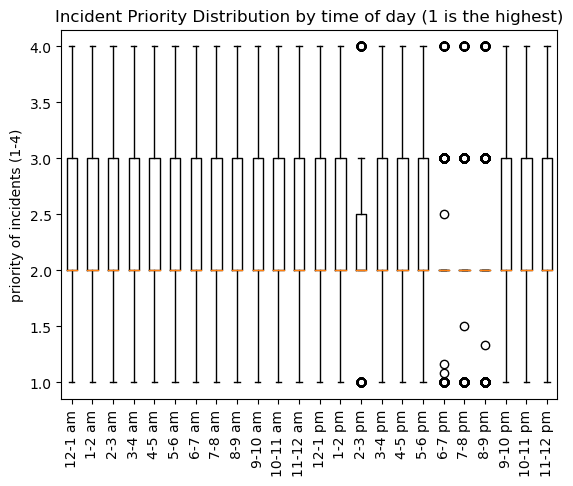

In [17]:
mean_hourly_activity = dfc.groupby(['hour', 'date','incident_number'])[['priority']].mean()
mean_hourly_activity  = mean_hourly_activity.reset_index().groupby('hour')['priority'].apply(list).to_dict()
fig, ax = plt.subplots()
ax.set_ylabel('priority of incidents (1-4)')
bplot = ax.boxplot(mean_hourly_activity.values(),
                   labels=["12-1 am", "1-2 am", "2-3 am", "3-4 am", "4-5 am", "5-6 am", "6-7 am", "7-8 am", "8-9 am", "9-10 am", "10-11 am", "11-12 am", "12-1 pm", "1-2 pm", "2-3 pm", "3-4 pm", "4-5 pm", "5-6 pm", "6-7 pm", "7-8 pm", "8-9 pm", "9-10 pm", "10-11 pm", "11-12 pm"])  # will be used to label x-ticks
plt.xticks(rotation = 90)
plt.title("Incident Priority Distribution by time of day (1 is the highest)")
plt.show()

In [18]:
# most prevalent call types 
call_counts = dfc.groupby('nature_of_call')['incident_number'].agg('count').reset_index().sort_values(by='incident_number', ascending = False)
call_counts_gt_20 = call_counts[call_counts['incident_number']>=20]['nature_of_call'].tolist()
len(call_counts_gt_20)

79

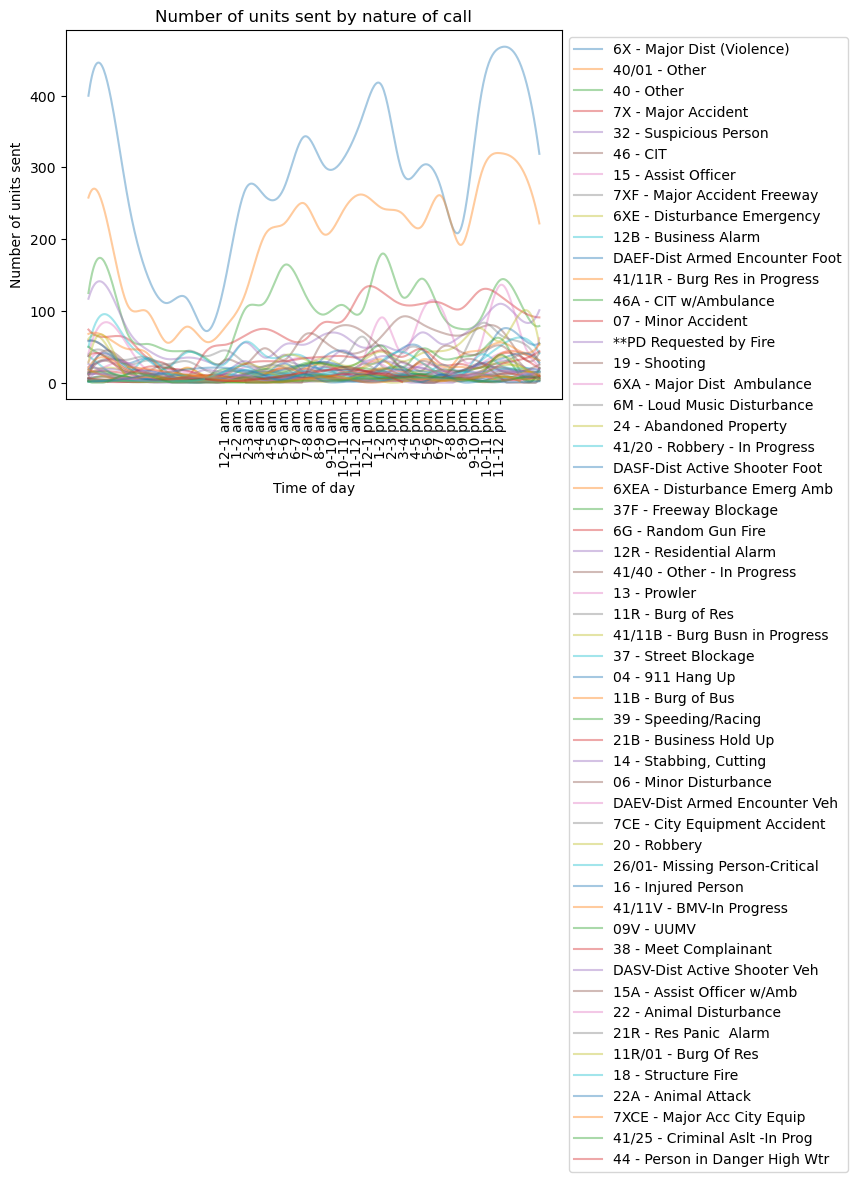

In [19]:
# call type trends 
# can dig into call types by time of day 
# dfc.groupby(['nature_of_call', 'hour'])['incident_number'].agg('count').reset_index().sort_values(by=['hour', 'incident_number'], ascending = False)

#number of units sent per hour per call nature 
for call in call_counts_gt_20:
    call_df = dfc[dfc['nature_of_call']==call].groupby('hour')['incident_number'].agg('count').reset_index()
    overlapping = 0.4
    x = call_df['hour']
    y = call_df['incident_number']
    if max(y.tolist())<10:
        continue
    try:
        X_Y_Spline = make_interp_spline(x, y)
    except:
        pass
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    Y_ = [0 if val < 0 else val for val in Y_]
    plt.plot(X_, Y_, alpha = overlapping, label=call)
    
plt.legend(loc  ='best', bbox_to_anchor=(1, 1))
hour_labels = ["12-1 am", "1-2 am", "2-3 am", "3-4 am", "4-5 am", "5-6 am", "6-7 am", "7-8 am", "8-9 am", "9-10 am", "10-11 am", "11-12 am", "12-1 pm", "1-2 pm", "2-3 pm", "3-4 pm", "4-5 pm", "5-6 pm", "6-7 pm", "7-8 pm", "8-9 pm", "9-10 pm", "10-11 pm", "11-12 pm"]
tick_positions = np.linspace(x.min(), x.max(), len(hour_labels))
plt.xticks(tick_positions, hour_labels, rotation=90)  # Rotate for better readabilityplt.tight_layout()
plt.title('Number of units sent by nature of call')
plt.xlabel("Time of day")
plt.ylabel("Number of units sent")
plt.show()

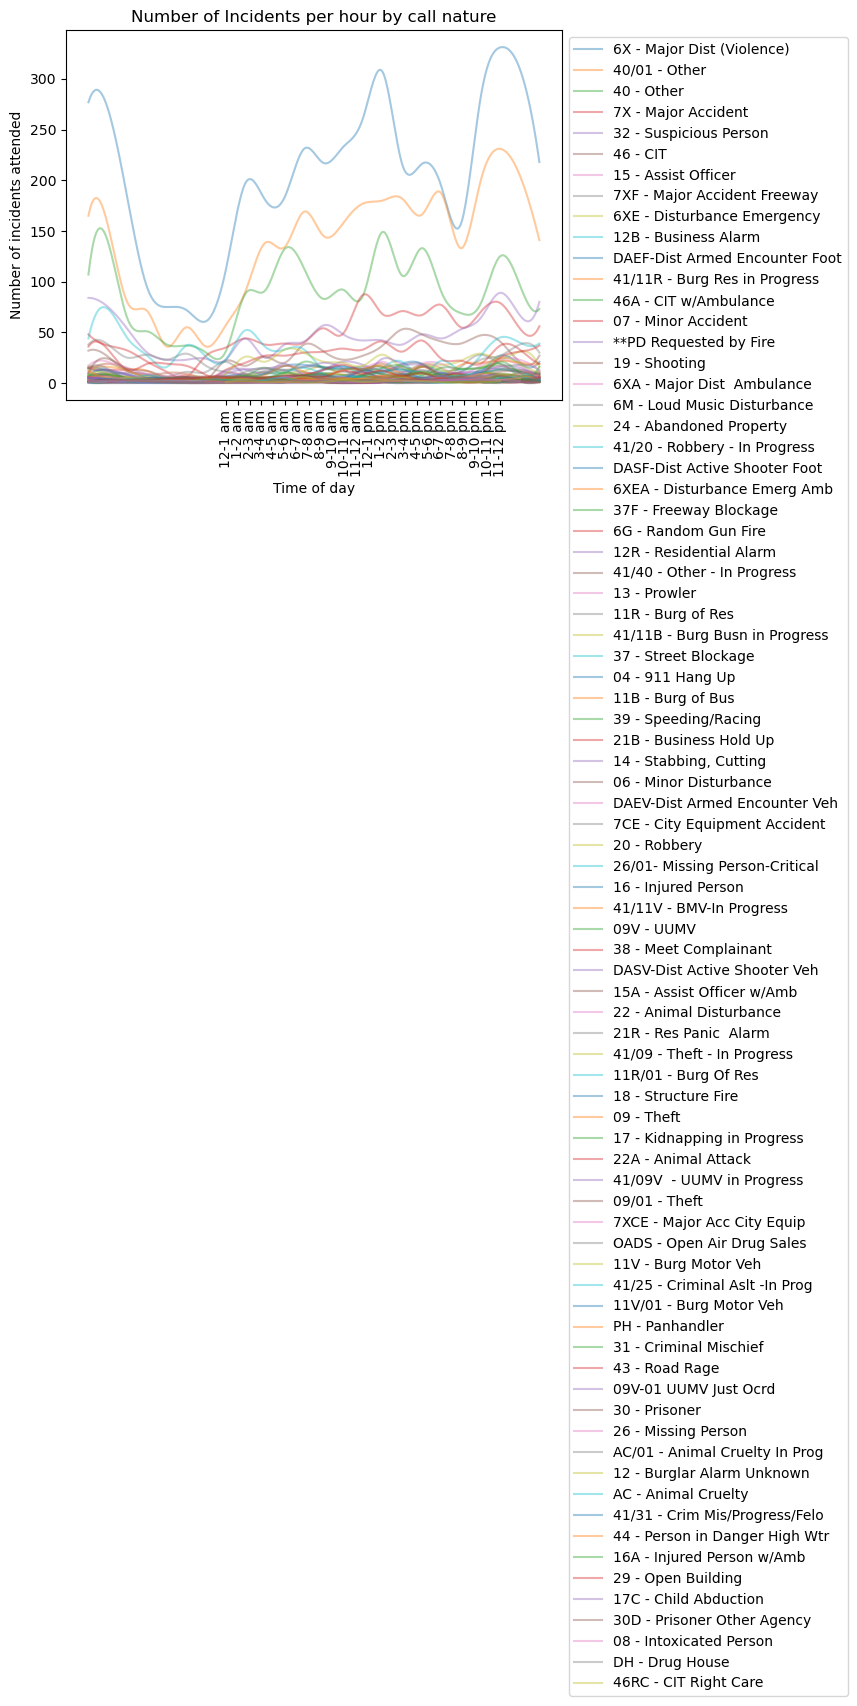

In [20]:
#number of units sent per hour per call nature 
dfu = dfc.drop(columns = ['unit_number'])
dfu = dfu.drop_duplicates()
for call in call_counts_gt_20:
    call_df = dfu[dfu['nature_of_call']==call].groupby('hour')['incident_number'].agg('count').reset_index()
    overlapping = 0.4
    x = call_df['hour']
    y = call_df['incident_number']
    try:
        X_Y_Spline = make_interp_spline(x, y)
    except:
        pass
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    Y_ = [0 if val < 0 else val for val in Y_]
    plt.plot(X_, Y_, alpha = overlapping, label=call)
    
plt.legend(loc  ='best', bbox_to_anchor=(1, 1))
hour_labels = ["12-1 am", "1-2 am", "2-3 am", "3-4 am", "4-5 am", "5-6 am", "6-7 am", "7-8 am", "8-9 am", "9-10 am", "10-11 am", "11-12 am", "12-1 pm", "1-2 pm", "2-3 pm", "3-4 pm", "4-5 pm", "5-6 pm", "6-7 pm", "7-8 pm", "8-9 pm", "9-10 pm", "10-11 pm", "11-12 pm"]
tick_positions = np.linspace(x.min(), x.max(), len(hour_labels))
plt.xticks(tick_positions, hour_labels, rotation=90)  # Rotate for better readabilityplt.tight_layout()
plt.title('Number of Incidents per hour by call nature')
plt.xlabel("Time of day")
plt.ylabel("Number of incidents attended")
plt.show()

In [21]:
result =  dfc['datetime'].max() - dfc['datetime'].min()
result.days

36

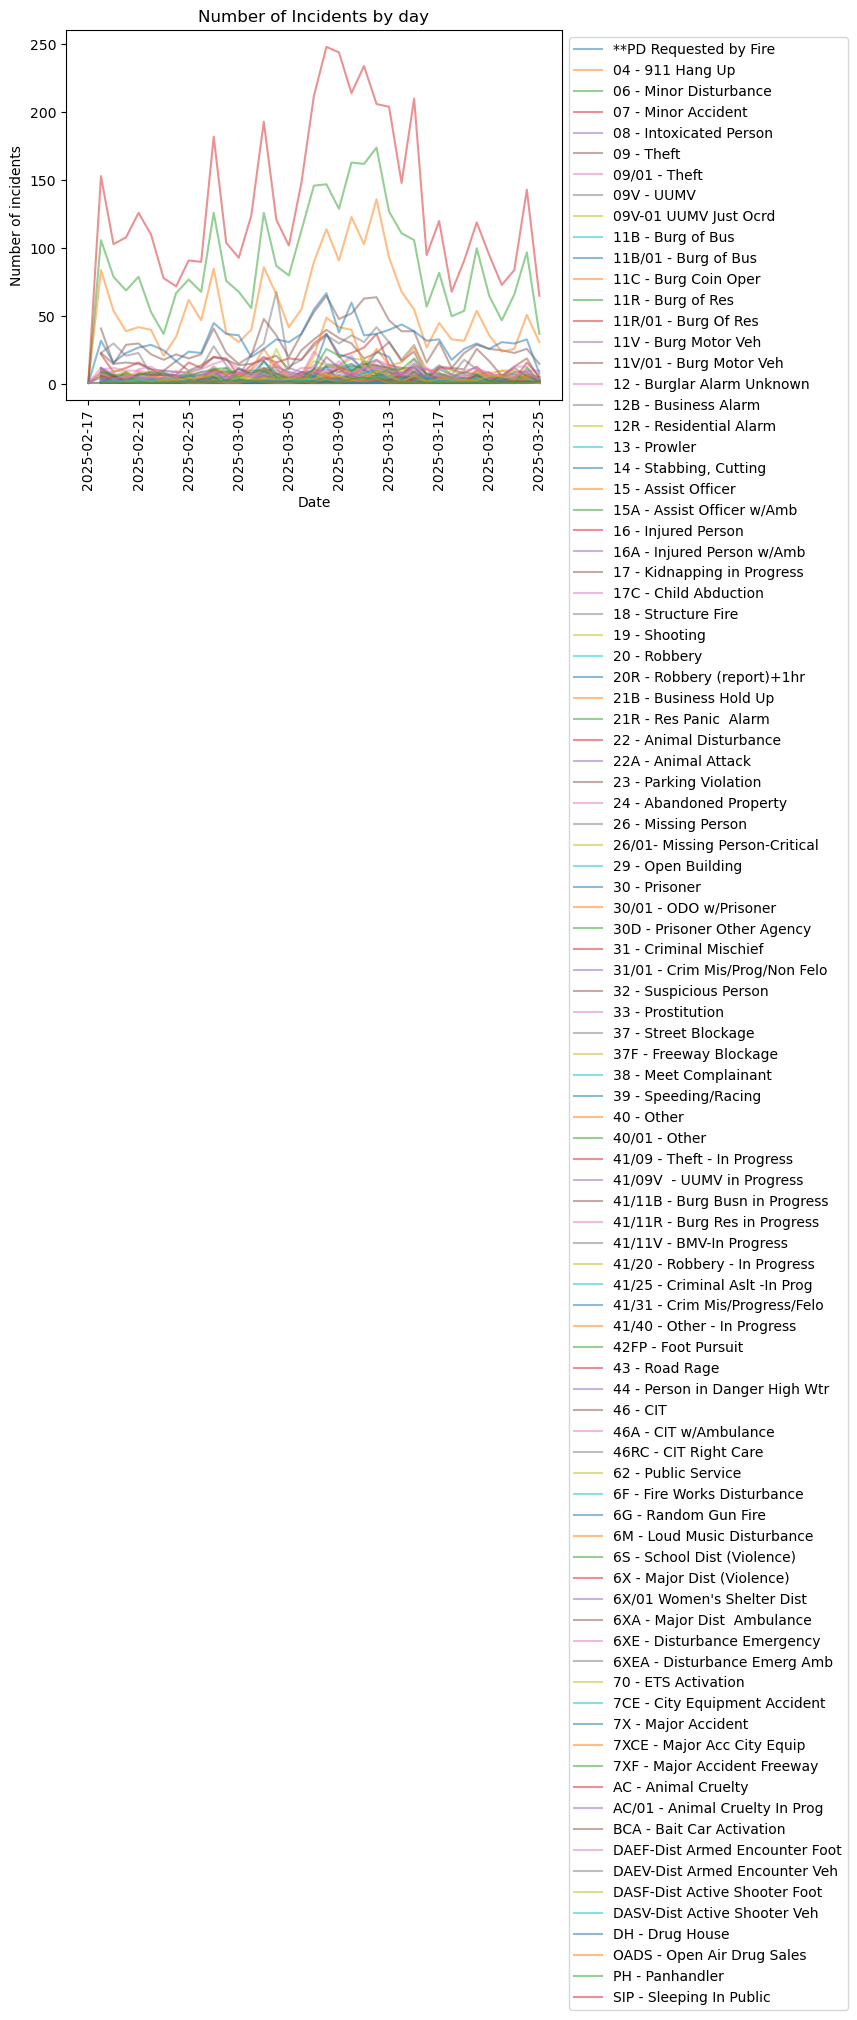

In [22]:
## number of incidents by type by date 
ibd = dfu.groupby(['nature_of_call', 'date'])['incident_number'].agg('count').reset_index().sort_values("nature_of_call")
for call_type in ibd['nature_of_call'].unique().tolist():
    ibd_sub = ibd[ibd['nature_of_call'] == call_type].drop(columns = ['nature_of_call']).sort_values('date')
    plt.plot(ibd_sub['date'], ibd_sub['incident_number'], alpha = .5, label = call_type)
    plt.xticks(rotation=90)
plt.legend(loc  ='best', bbox_to_anchor=(1, 1))
plt.title('Number of Incidents by day')
plt.xlabel("Date")
plt.ylabel("Number of incidents")
plt.show()

In [23]:
dfc[dfc['date'] == "2025-02-18"].groupby('nature_of_call')['incident_number'].agg('count').reset_index().sort_values("incident_number", ascending = False)

,nature_of_call,incident_number
57,6X - Major Dist (Violence),213
42,40/01 - Other,159
41,40 - Other,96
62,7X - Major Accident,69
36,32 - Suspicious Person,62
...,...,...
23,17C - Child Abduction,1
22,16A - Injured Person w/Amb,1
5,09 - Theft,1
4,08 - Intoxicated Person,1


In [24]:
# for past x hours 
def get_date_range(num_days):
    now = datetime.datetime.now()
    day_range = datetime.timedelta(num_days)
    return datetime.datetime.now()-day_range

def get_data_date_range():
    num_days = int(input("get data for the past _ days"))
    start = get_date_range(num_days)
    return dfc[dfc['datetime'] >= start]

In [25]:
get_data_date_range().head()

get data for the past _ days 7


,incident_number,division,nature_of_call,priority,date,time,unit_number,location,beat,reporting_area,status,block,datetime,day,hour,minute
31065,25-0468565,Central,15 - Assist Officer,1,2025-03-18,15:37:01,L302,MAIN ST,134,2063,At Scene,1800,2025-03-18 15:37:01,18,15,37
31066,25-0468294,North Central,40/01 - Other,2,2025-03-18,15:39:38,C614,Verde Valley Ln,631,1008,At Scene,5200,2025-03-18 15:39:38,18,15,39
31067,25-0468419,Southeast,40/01 - Other,2,2025-03-18,15:54:32,C310,Wofford Dr,321,1235,At Scene,7000,2025-03-18 15:54:32,18,15,54
31068,25-0468642,Southwest,DAEV-Dist Armed Encounter Veh,1,2025-03-18,15:58:39,C416,Woodall Rodgers Fwy Wb,424,2403,At Scene,100,2025-03-18 15:58:39,18,15,58
31069,25-0467780,Southeast,26/01- Missing Person-Critical,1,2025-03-18,16:10:28,C323,Fairway Ave,315,1232,At Scene,5900,2025-03-18 16:10:28,18,16,10


In [26]:
dfu.groupby('date')['incident_number'].agg('count').reset_index()

,date,incident_number
0,2025-02-17,16
1,2025-02-18,756
2,2025-02-19,485
3,2025-02-20,492
4,2025-02-21,531
5,2025-02-22,454
6,2025-02-23,350
7,2025-02-24,377
8,2025-02-25,461
9,2025-02-26,445


# next steps 
- what can this data do to help the pd
    Scheduling, shifts, number of units
    distribution of resources 
    
    

In [33]:
dfc.columns

Index(['incident_number', 'division', 'nature_of_call', 'priority', 'date',
       'time', 'unit_number', 'location', 'beat', 'reporting_area', 'status',
       'block', 'datetime', 'day', 'hour', 'minute'],
      dtype='object')

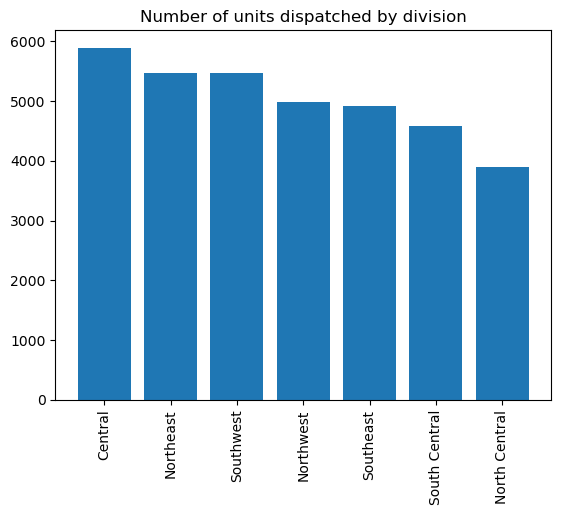

In [34]:
#total number of units dispatched by division 
div_df = dfc.groupby('division')['incident_number'].agg('count').reset_index().sort_values('incident_number', ascending = False)
plt.bar(div_df['division'], div_df['incident_number'])
plt.xticks(rotation=90)
plt.title("Number of units dispatched by division")
plt.show()

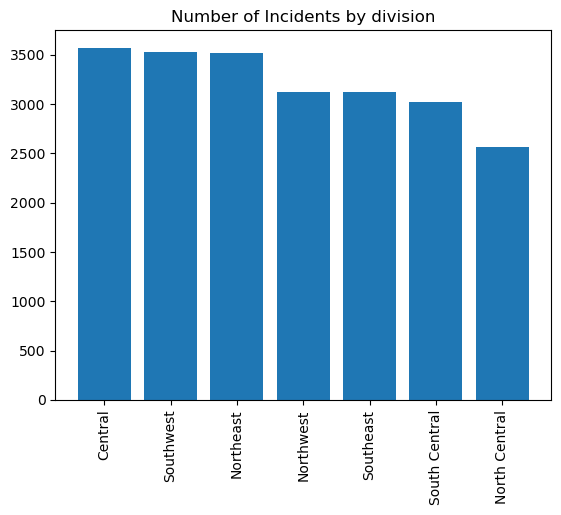

In [29]:
div_df = dfu.groupby('division')['incident_number'].agg('count').reset_index().sort_values('incident_number', ascending = False)
plt.bar(div_df['division'], div_df['incident_number'])
plt.xticks(rotation=90)
plt.title("Number of Incidents by division")
plt.show()

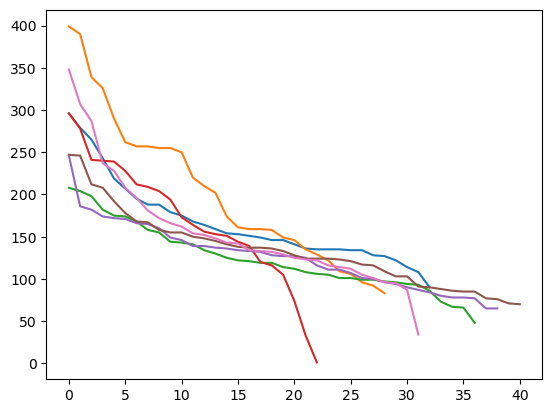

In [30]:
#graphical comparison of number of units being sent out by division, x data aranged from most to least amount by beats 
for division in dfc['division'].unique().tolist(): # 7 divisions 
    temp_df = dfc[dfc['division'] == division].groupby('beat')['incident_number'].agg('count').reset_index().sort_values('incident_number', ascending = False)
    plt.plot(np.arange(len(temp_df)), temp_df['incident_number'])


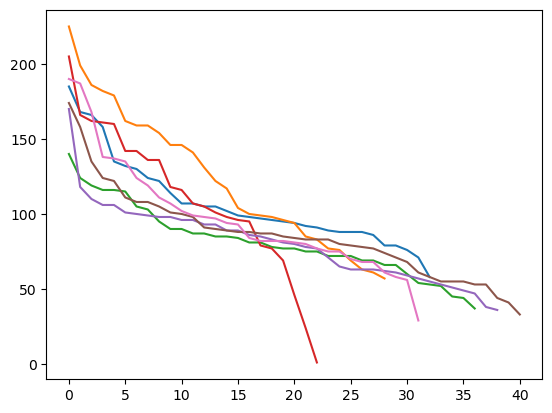

In [31]:
#graphical comparison of number of incidents occuring by division x data aranged from most to least amount by beats 
for division in dfu['division'].unique().tolist(): # 7 divisions 
    temp_df = dfu[dfu['division'] == division].groupby('beat')['incident_number'].agg('count').reset_index().sort_values('incident_number', ascending = False)
    plt.plot(np.arange(len(temp_df)), temp_df['incident_number'])


In [32]:
# how many units needed per district based on current incidents being reported?
for division in dfc['division'].unique().tolist(): # 7 divisions 
    

SyntaxError: incomplete input (3619603022.py, line 3)